## Introduction and setup

In [47]:
# Import the required libraries

import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
SEED = 0
seed_everything(SEED)

## TPU configuration

In [48]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470


2022-12-06 20:10:21.986044: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-06 20:10:21.986114: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30021}
2022-12-06 20:10:21.988062: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-06 20:10:21.988098: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30021}


REPLICAS: 8


# Model parameters

In [49]:
# Defining model parameters

HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 100
TRANSFORMER_BLOCKS = 8
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

# Load data

In [50]:
# Loading the monet painting and photo dataset

data_path = KaggleDatasets().get_gcs_path('gan-getting-started')

monet_file = tf.io.gfile.glob(str(data_path + '/monet_tfrec/monet*.tfrec'))
photo_file = tf.io.gfile.glob(str(data_path + '/photo_tfrec/photo*.tfrec'))

def image_data_count(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

monet_samples = image_data_count(monet_file)
photo_samples = image_data_count(photo_file)

print(f'Monet TFRecord files: {len(monet_file)}')
print(f'Monet image files: {monet_samples}')
print(f'Photo TFRecord files: {len(photo_file)}')
print(f'Photo image files: {photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


2022-12-06 20:10:28.551188: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-06 20:10:28.598649: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


# Augmentations

In [89]:
monet_aug_data = load_dataset(monet_file).batch(1)
photo_aug_data = load_dataset(photo_file).batch(1)

In [90]:
ex_monet = next(iter(monet_aug_data))
ex_photo = next(iter(photo_aug_data))

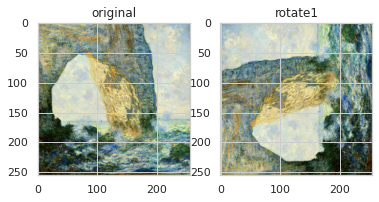

In [91]:
# Performing rotations on the input dataset

def data_augment_rotate1(image):
    image = tf.image.rot90(image, k=1)
    return image
def data_augment_rotate2(image):
    image = tf.image.rot90(image, k=2)
    return image
def data_augment_rotate3(image):
    image = tf.image.rot90(image, k=3)
    return image

plt.subplot(121)
plt.title('original')
plt.imshow(ex_monet[0])

image = data_augment_rotate1(ex_monet)
plt.subplot(122)
plt.title('rotate1')
plt.imshow(image[0])

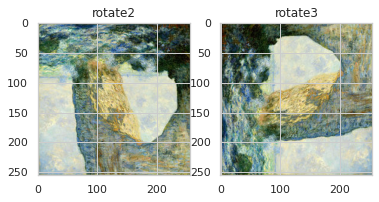

In [92]:
image = data_augment_rotate2(ex_monet)
plt.subplot(121)
plt.title('rotate2')
plt.imshow(image[0])

image = data_augment_rotate3(ex_monet)
plt.subplot(122)
plt.title('rotate3')
plt.imshow(image[0])

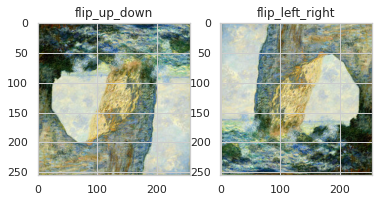

In [93]:
# Performing flips on input dataset as part of augmentation

def flip_up_down(image):
    image = tf.image.flip_up_down(image)
    return image
def flip_left_right(image):
    image = tf.image.flip_left_right(image)
    return image
image = flip_up_down(ex_monet)
plt.subplot(121)
plt.title('flip_up_down')
plt.imshow(image[0])

image = flip_left_right(ex_monet)
plt.subplot(122)
plt.title('flip_left_right')
plt.imshow(image[0])

In [56]:
# Complete dataset augmentation before performing GAN

def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
       
    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    return image

## Functions for loading image dataset

In [57]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)
    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)  
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        f = plt.figure(figsize=(12, 12))
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)
        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')
        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')
        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')
    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

## Encoder, Transformation and Decoder Layer

In [58]:
# Convolutional layer block for encoder, decoder and transformtion block

conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
    block = L.LeakyReLU()(block)
    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)
    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

# Generator model

In [59]:
# Generator function with encoder, transformation and decoder

def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1')
    enc_2 = encoder_block(enc_1, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}')

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 256, 3, 2, apply_instancenorm=True, name='block_1')
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2')
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip)

    generator = Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
sample_generator.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder_block_1 (Conv2D)        (None, 256, 256, 64) 9408        input_image[0][0]                
__________________________________________________________________________________________________
re_lu_99 (ReLU)                 (None, 256, 256, 64) 0           encoder_block_1[0][0]            
__________________________________________________________________________________________________
encoder_block_2 (Conv2D)        (None, 128, 128, 256 147456      re_lu_99[0][0]                   
___________________________________________________________________________________________

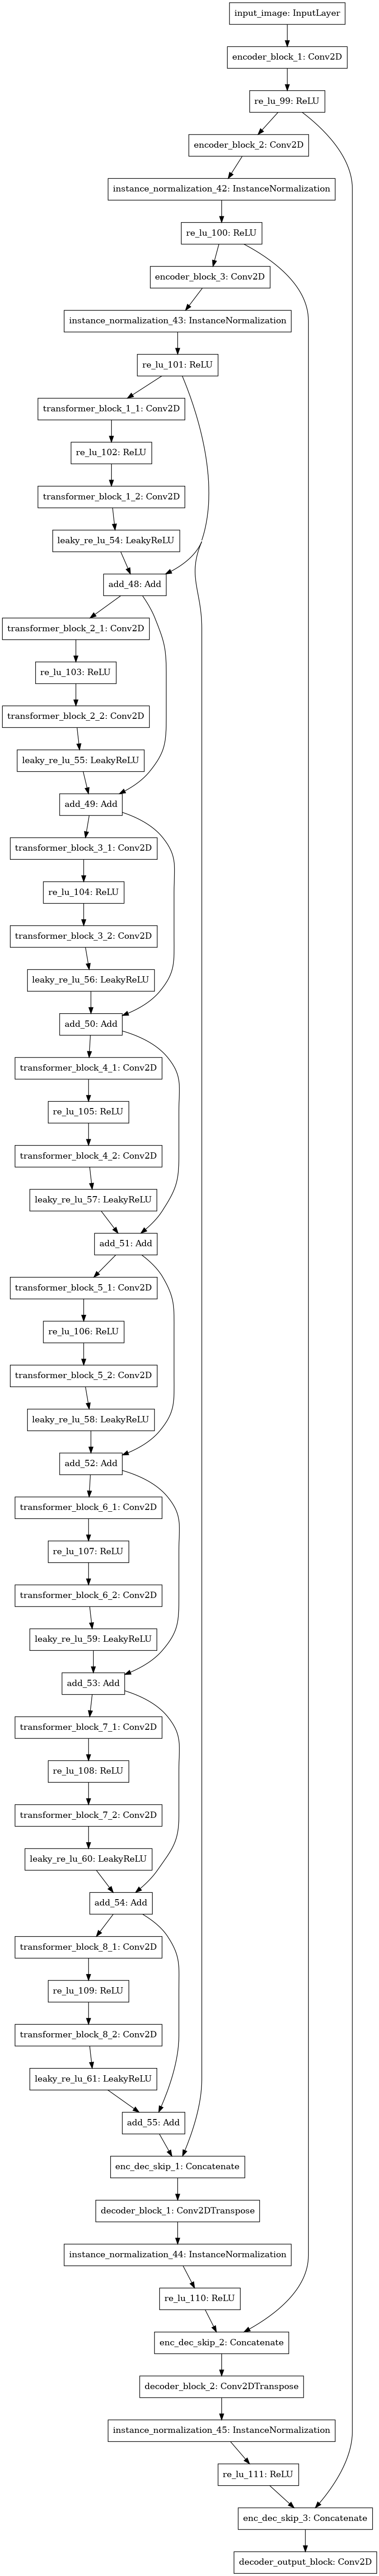

In [60]:
plot_model(sample_generator, to_file = 'model_structure_plot.png', show_layer_names = True)

# Discriminator model

In [61]:
# Discriminator function with Encoder for input

def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1')
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=L.ReLU(0.2), name='block_2')
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.ReLU(0.2), name='block_3')
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.ReLU(0.2), name='block_4')

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)
    discriminator = Model(inputs, outputs)
    return discriminator

sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_block_1 (Conv2D)     (None, 128, 128, 64)      3072      
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_block_2 (Conv2D)     (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_46 (I (None, 64, 64, 128)       256       
_________________________________________________________________
re_lu_112 (ReLU)             (None, 64, 64, 128)       0         
_________________________________________________________________
encoder_block_3 (Conv2D)     (None, 32, 32, 256)       524

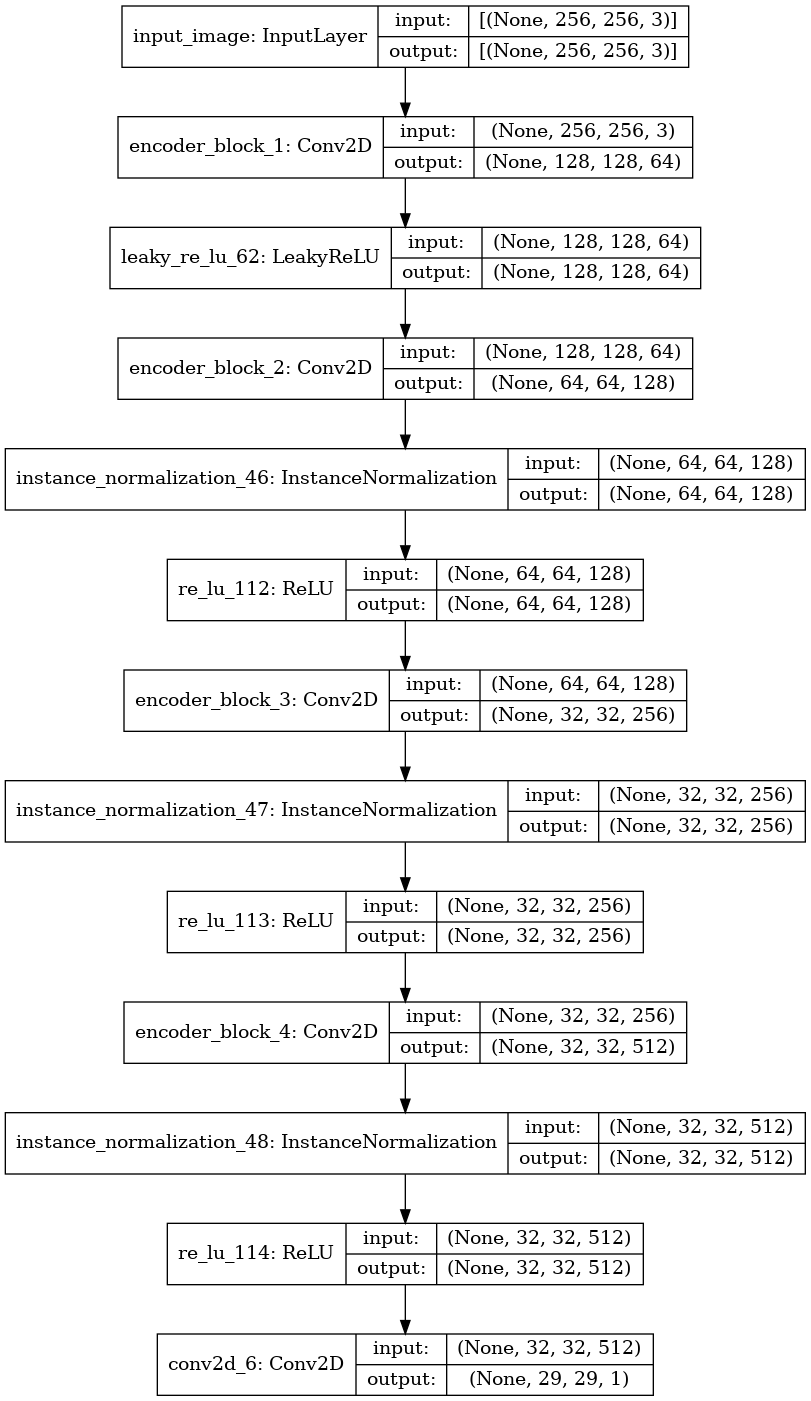

In [62]:
plot_model(sample_discriminator, to_file = 'model_discriminator_plot.png', show_shapes = True, show_layer_names = True)

# Build model (CycleGAN)

In [63]:
# Building GAN structure for monet and photo image using Generator and Discriminator

with strategy.scope():
    monet_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
    photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        monet_gentransform_loss = []
        monet_gentransform_loss.append(total_monet_gen_loss)
        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

# Loss functions

In [64]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

## Learning rate schedule

In [95]:
@tf.function
def linear_schedule_with_warmup(step):
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(monet_samples, photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(monet_samples, photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')

100 total epochs and 219 steps per epoch


# Train

In [66]:
with strategy.scope():
    # Create generators
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

In [67]:
# Create dataset
monet_dataset = get_dataset(monet_file, augment=data_augment, batch_size=BATCH_SIZE)
photo_dataset = get_dataset(photo_file, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_dataset, photo_dataset))

photo_ds_eval = get_dataset(photo_file, repeat=False, shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(monet_file, repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(Callback):
    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')

In [69]:
history = gan_model.fit(gan_ds, 
                        epochs=EPOCHS, 
                        callbacks=[GANMonitor()], 
                        steps_per_epoch=(max(monet_samples, photo_samples)//BATCH_SIZE), 
                        verbose=2).history

Epoch 1/100
219/219 - 108s - monet_gen_loss: 3.1787 - photo_gen_loss: 3.4607 - monet_disc_loss: 0.5585 - photo_disc_loss: 0.5597


2022-12-06 20:12:26.547180: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 54252, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670357546.547099290","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 54252, Output num: 0","grpc_status":3}


Epoch 2/100
219/219 - 29s - monet_gen_loss: 2.7871 - photo_gen_loss: 3.0905 - monet_disc_loss: 0.4467 - photo_disc_loss: 0.4341
Epoch 3/100
219/219 - 29s - monet_gen_loss: 2.7718 - photo_gen_loss: 2.5484 - monet_disc_loss: 0.5941 - photo_disc_loss: 0.4877
Epoch 4/100
219/219 - 29s - monet_gen_loss: 2.7690 - photo_gen_loss: 3.0115 - monet_disc_loss: 0.5511 - photo_disc_loss: 0.4353


2022-12-06 20:13:54.675859: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 56661, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670357634.675763593","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 56661, Output num: 0","grpc_status":3}


Epoch 5/100
219/219 - 29s - monet_gen_loss: 2.3721 - photo_gen_loss: 2.4835 - monet_disc_loss: 0.5274 - photo_disc_loss: 0.6652
Epoch 6/100
219/219 - 29s - monet_gen_loss: 2.0427 - photo_gen_loss: 2.3172 - monet_disc_loss: 0.6619 - photo_disc_loss: 0.6539
Epoch 7/100
219/219 - 29s - monet_gen_loss: 2.4352 - photo_gen_loss: 2.5665 - monet_disc_loss: 0.8232 - photo_disc_loss: 0.5719


2022-12-06 20:15:22.881262: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 59070, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670357722.881160999","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 59070, Output num: 0","grpc_status":3}


Epoch 8/100
219/219 - 29s - monet_gen_loss: 1.9112 - photo_gen_loss: 2.3610 - monet_disc_loss: 0.7532 - photo_disc_loss: 0.4886
Epoch 9/100
219/219 - 29s - monet_gen_loss: 2.0870 - photo_gen_loss: 2.4525 - monet_disc_loss: 0.6880 - photo_disc_loss: 0.6409
Epoch 10/100
219/219 - 29s - monet_gen_loss: 1.9746 - photo_gen_loss: 2.2561 - monet_disc_loss: 0.6859 - photo_disc_loss: 0.7431


2022-12-06 20:16:51.056140: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61479, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670357811.055982886","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61479, Output num: 0","grpc_status":3}


Epoch 11/100
219/219 - 29s - monet_gen_loss: 2.6327 - photo_gen_loss: 2.2766 - monet_disc_loss: 0.5728 - photo_disc_loss: 0.5726
Epoch 12/100
219/219 - 29s - monet_gen_loss: 2.0104 - photo_gen_loss: 2.5112 - monet_disc_loss: 0.6827 - photo_disc_loss: 0.5697
Epoch 13/100
219/219 - 29s - monet_gen_loss: 2.0882 - photo_gen_loss: 2.4377 - monet_disc_loss: 0.5549 - photo_disc_loss: 0.5219


2022-12-06 20:18:19.339553: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 63888, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670357899.339353768","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 63888, Output num: 0","grpc_status":3}


Epoch 14/100
219/219 - 29s - monet_gen_loss: 1.8627 - photo_gen_loss: 2.6164 - monet_disc_loss: 0.6306 - photo_disc_loss: 0.5554
Epoch 15/100
219/219 - 29s - monet_gen_loss: 1.8804 - photo_gen_loss: 2.3182 - monet_disc_loss: 0.7212 - photo_disc_loss: 0.5567
Epoch 16/100
219/219 - 29s - monet_gen_loss: 2.2059 - photo_gen_loss: 2.6817 - monet_disc_loss: 0.6898 - photo_disc_loss: 0.7578


2022-12-06 20:19:47.703142: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 66297, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670357987.702949185","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 66297, Output num: 0","grpc_status":3}


Epoch 17/100
219/219 - 29s - monet_gen_loss: 1.5936 - photo_gen_loss: 2.3153 - monet_disc_loss: 0.7208 - photo_disc_loss: 0.6753
Epoch 18/100
219/219 - 29s - monet_gen_loss: 2.3759 - photo_gen_loss: 2.2566 - monet_disc_loss: 0.5780 - photo_disc_loss: 0.5927
Epoch 19/100
219/219 - 29s - monet_gen_loss: 2.3430 - photo_gen_loss: 2.9061 - monet_disc_loss: 0.6291 - photo_disc_loss: 0.2798


2022-12-06 20:21:15.955231: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 68706, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358075.955143843","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 68706, Output num: 0","grpc_status":3}


Epoch 20/100
219/219 - 29s - monet_gen_loss: 2.3899 - photo_gen_loss: 2.4283 - monet_disc_loss: 0.5523 - photo_disc_loss: 0.4505
Epoch 21/100
219/219 - 29s - monet_gen_loss: 2.2372 - photo_gen_loss: 2.5674 - monet_disc_loss: 0.5861 - photo_disc_loss: 0.4157
Epoch 22/100
219/219 - 29s - monet_gen_loss: 1.9503 - photo_gen_loss: 2.4482 - monet_disc_loss: 0.5990 - photo_disc_loss: 0.6015


2022-12-06 20:22:44.226377: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 71115, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358164.226251027","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 71115, Output num: 0","grpc_status":3}


Epoch 23/100
219/219 - 29s - monet_gen_loss: 2.1402 - photo_gen_loss: 2.5320 - monet_disc_loss: 0.5771 - photo_disc_loss: 0.4362
Epoch 24/100
219/219 - 29s - monet_gen_loss: 2.1490 - photo_gen_loss: 2.3592 - monet_disc_loss: 0.6492 - photo_disc_loss: 0.4076
Epoch 25/100
219/219 - 29s - monet_gen_loss: 2.2921 - photo_gen_loss: 3.0798 - monet_disc_loss: 0.5548 - photo_disc_loss: 0.4262


2022-12-06 20:24:12.654816: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 73524, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358252.654725768","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 73524, Output num: 0","grpc_status":3}


Epoch 26/100
219/219 - 29s - monet_gen_loss: 2.2538 - photo_gen_loss: 2.3665 - monet_disc_loss: 0.5989 - photo_disc_loss: 0.7570
Epoch 27/100
219/219 - 29s - monet_gen_loss: 2.2498 - photo_gen_loss: 2.9370 - monet_disc_loss: 0.6897 - photo_disc_loss: 0.4094
Epoch 28/100
219/219 - 29s - monet_gen_loss: 2.2190 - photo_gen_loss: 2.3979 - monet_disc_loss: 0.5813 - photo_disc_loss: 0.5561


2022-12-06 20:25:40.978319: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 75933, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358340.978186450","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 75933, Output num: 0","grpc_status":3}


Epoch 29/100
219/219 - 29s - monet_gen_loss: 2.4302 - photo_gen_loss: 3.3378 - monet_disc_loss: 0.7033 - photo_disc_loss: 0.6503
Epoch 30/100
219/219 - 29s - monet_gen_loss: 2.1898 - photo_gen_loss: 2.1973 - monet_disc_loss: 0.5827 - photo_disc_loss: 0.7351
Epoch 31/100
219/219 - 29s - monet_gen_loss: 2.8910 - photo_gen_loss: 2.9938 - monet_disc_loss: 0.4640 - photo_disc_loss: 0.4221


2022-12-06 20:27:09.277451: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 78342, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358429.276940649","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 78342, Output num: 0","grpc_status":3}


Epoch 32/100
219/219 - 29s - monet_gen_loss: 2.2151 - photo_gen_loss: 2.3727 - monet_disc_loss: 0.5673 - photo_disc_loss: 0.5732
Epoch 33/100
219/219 - 29s - monet_gen_loss: 1.9138 - photo_gen_loss: 2.1173 - monet_disc_loss: 0.6780 - photo_disc_loss: 0.5851
Epoch 34/100
219/219 - 29s - monet_gen_loss: 2.2891 - photo_gen_loss: 2.9188 - monet_disc_loss: 0.6030 - photo_disc_loss: 0.3041


2022-12-06 20:28:37.685297: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 80751, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358517.685096794","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 80751, Output num: 0","grpc_status":3}


Epoch 35/100
219/219 - 29s - monet_gen_loss: 2.4093 - photo_gen_loss: 2.3476 - monet_disc_loss: 0.6121 - photo_disc_loss: 0.7226
Epoch 36/100
219/219 - 29s - monet_gen_loss: 2.2506 - photo_gen_loss: 2.3750 - monet_disc_loss: 0.6842 - photo_disc_loss: 0.8941
Epoch 37/100
219/219 - 29s - monet_gen_loss: 2.2651 - photo_gen_loss: 2.3870 - monet_disc_loss: 0.6080 - photo_disc_loss: 0.5102


2022-12-06 20:30:06.104903: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 83160, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358606.104821049","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 83160, Output num: 0","grpc_status":3}


Epoch 38/100
219/219 - 29s - monet_gen_loss: 2.0225 - photo_gen_loss: 2.2268 - monet_disc_loss: 0.7106 - photo_disc_loss: 0.6245
Epoch 39/100
219/219 - 29s - monet_gen_loss: 1.9770 - photo_gen_loss: 1.9583 - monet_disc_loss: 0.6606 - photo_disc_loss: 0.7008
Epoch 40/100
219/219 - 29s - monet_gen_loss: 2.1116 - photo_gen_loss: 2.8582 - monet_disc_loss: 0.7485 - photo_disc_loss: 0.5474


2022-12-06 20:31:34.512402: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 85569, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358694.512207215","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 85569, Output num: 0","grpc_status":3}


Epoch 41/100
219/219 - 29s - monet_gen_loss: 2.7044 - photo_gen_loss: 2.6101 - monet_disc_loss: 0.4129 - photo_disc_loss: 0.5962
Epoch 42/100
219/219 - 29s - monet_gen_loss: 2.1642 - photo_gen_loss: 2.8018 - monet_disc_loss: 0.5919 - photo_disc_loss: 0.6099
Epoch 43/100
219/219 - 29s - monet_gen_loss: 2.4180 - photo_gen_loss: 2.2594 - monet_disc_loss: 0.5444 - photo_disc_loss: 0.5893


2022-12-06 20:33:03.013972: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 87978, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358783.013859694","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 87978, Output num: 0","grpc_status":3}


Epoch 44/100
219/219 - 29s - monet_gen_loss: 2.3024 - photo_gen_loss: 2.4579 - monet_disc_loss: 0.6540 - photo_disc_loss: 0.5479
Epoch 45/100
219/219 - 29s - monet_gen_loss: 2.2392 - photo_gen_loss: 2.3865 - monet_disc_loss: 0.4843 - photo_disc_loss: 0.5988
Epoch 46/100
219/219 - 29s - monet_gen_loss: 2.2975 - photo_gen_loss: 2.2885 - monet_disc_loss: 0.5369 - photo_disc_loss: 0.5164


2022-12-06 20:34:31.410279: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 90387, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358871.410197920","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 90387, Output num: 0","grpc_status":3}


Epoch 47/100
219/219 - 29s - monet_gen_loss: 2.0395 - photo_gen_loss: 2.5105 - monet_disc_loss: 0.8294 - photo_disc_loss: 0.6452
Epoch 48/100
219/219 - 29s - monet_gen_loss: 2.5959 - photo_gen_loss: 2.8020 - monet_disc_loss: 0.6267 - photo_disc_loss: 0.6090
Epoch 49/100
219/219 - 29s - monet_gen_loss: 2.3466 - photo_gen_loss: 2.6382 - monet_disc_loss: 0.4916 - photo_disc_loss: 0.6565


2022-12-06 20:35:59.863409: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 92796, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670358959.863298334","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 92796, Output num: 0","grpc_status":3}


Epoch 50/100
219/219 - 29s - monet_gen_loss: 2.2930 - photo_gen_loss: 2.6111 - monet_disc_loss: 0.6383 - photo_disc_loss: 0.5955
Epoch 51/100
219/219 - 29s - monet_gen_loss: 2.3745 - photo_gen_loss: 2.5928 - monet_disc_loss: 0.5353 - photo_disc_loss: 0.5736
Epoch 52/100
219/219 - 29s - monet_gen_loss: 2.3639 - photo_gen_loss: 2.2948 - monet_disc_loss: 0.7743 - photo_disc_loss: 0.4491


2022-12-06 20:37:28.302499: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 95205, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359048.302340412","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 95205, Output num: 0","grpc_status":3}


Epoch 53/100
219/219 - 29s - monet_gen_loss: 2.6502 - photo_gen_loss: 2.6510 - monet_disc_loss: 0.6803 - photo_disc_loss: 0.5896
Epoch 54/100
219/219 - 29s - monet_gen_loss: 2.6035 - photo_gen_loss: 2.5743 - monet_disc_loss: 0.5199 - photo_disc_loss: 0.6439
Epoch 55/100
219/219 - 29s - monet_gen_loss: 2.1725 - photo_gen_loss: 2.5795 - monet_disc_loss: 0.6633 - photo_disc_loss: 0.6282


2022-12-06 20:38:56.668649: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 97614, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359136.668433332","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 97614, Output num: 0","grpc_status":3}


Epoch 56/100
219/219 - 29s - monet_gen_loss: 2.8611 - photo_gen_loss: 2.5292 - monet_disc_loss: 0.4279 - photo_disc_loss: 0.5880
Epoch 57/100
219/219 - 29s - monet_gen_loss: 2.6154 - photo_gen_loss: 3.1701 - monet_disc_loss: 0.6251 - photo_disc_loss: 0.3647
Epoch 58/100
219/219 - 29s - monet_gen_loss: 2.7677 - photo_gen_loss: 2.4812 - monet_disc_loss: 0.6677 - photo_disc_loss: 0.8365


2022-12-06 20:40:25.001526: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 100023, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359225.001405413","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 100023, Output num: 0","grpc_status":3}


Epoch 59/100
219/219 - 29s - monet_gen_loss: 2.4207 - photo_gen_loss: 2.5864 - monet_disc_loss: 0.6524 - photo_disc_loss: 0.5974
Epoch 60/100
219/219 - 29s - monet_gen_loss: 2.5644 - photo_gen_loss: 2.8830 - monet_disc_loss: 0.6893 - photo_disc_loss: 0.7008
Epoch 61/100
219/219 - 29s - monet_gen_loss: 2.9030 - photo_gen_loss: 2.6066 - monet_disc_loss: 0.5666 - photo_disc_loss: 0.4474


2022-12-06 20:41:53.373056: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 102432, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359313.372647438","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 102432, Output num: 0","grpc_status":3}


Epoch 62/100
219/219 - 29s - monet_gen_loss: 3.2108 - photo_gen_loss: 2.6038 - monet_disc_loss: 0.5784 - photo_disc_loss: 0.5734
Epoch 63/100
219/219 - 29s - monet_gen_loss: 2.4531 - photo_gen_loss: 3.0529 - monet_disc_loss: 0.4845 - photo_disc_loss: 0.4589
Epoch 64/100
219/219 - 29s - monet_gen_loss: 3.1743 - photo_gen_loss: 3.4155 - monet_disc_loss: 0.6708 - photo_disc_loss: 0.7093


2022-12-06 20:43:21.834734: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 104841, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359401.834592640","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 104841, Output num: 0","grpc_status":3}


Epoch 65/100
219/219 - 29s - monet_gen_loss: 2.3479 - photo_gen_loss: 2.7574 - monet_disc_loss: 0.6274 - photo_disc_loss: 0.5447
Epoch 66/100
219/219 - 29s - monet_gen_loss: 2.4853 - photo_gen_loss: 2.6075 - monet_disc_loss: 0.5246 - photo_disc_loss: 0.5454
Epoch 67/100
219/219 - 29s - monet_gen_loss: 2.2249 - photo_gen_loss: 3.3616 - monet_disc_loss: 0.6711 - photo_disc_loss: 0.6540


2022-12-06 20:44:50.303446: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 107250, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359490.303315525","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 107250, Output num: 0","grpc_status":3}


Epoch 68/100
219/219 - 29s - monet_gen_loss: 2.7545 - photo_gen_loss: 3.0739 - monet_disc_loss: 0.5004 - photo_disc_loss: 0.6906
Epoch 69/100
219/219 - 29s - monet_gen_loss: 2.9495 - photo_gen_loss: 2.6564 - monet_disc_loss: 0.4121 - photo_disc_loss: 0.4221
Epoch 70/100
219/219 - 29s - monet_gen_loss: 2.8336 - photo_gen_loss: 2.6034 - monet_disc_loss: 0.3711 - photo_disc_loss: 0.5438


2022-12-06 20:46:18.846389: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 109659, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359578.846239741","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 109659, Output num: 0","grpc_status":3}


Epoch 71/100
219/219 - 29s - monet_gen_loss: 3.0194 - photo_gen_loss: 2.9014 - monet_disc_loss: 0.4087 - photo_disc_loss: 0.4816
Epoch 72/100
219/219 - 29s - monet_gen_loss: 3.4357 - photo_gen_loss: 3.0212 - monet_disc_loss: 0.5421 - photo_disc_loss: 0.3849
Epoch 73/100
219/219 - 29s - monet_gen_loss: 3.1277 - photo_gen_loss: 2.7606 - monet_disc_loss: 0.6262 - photo_disc_loss: 0.4657


2022-12-06 20:47:47.253225: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 112068, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359667.253137194","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 112068, Output num: 0","grpc_status":3}


Epoch 74/100
219/219 - 29s - monet_gen_loss: 2.9059 - photo_gen_loss: 2.8253 - monet_disc_loss: 0.3334 - photo_disc_loss: 0.3571
Epoch 75/100
219/219 - 29s - monet_gen_loss: 3.0316 - photo_gen_loss: 2.6273 - monet_disc_loss: 0.6698 - photo_disc_loss: 0.7054
Epoch 76/100
219/219 - 29s - monet_gen_loss: 2.5845 - photo_gen_loss: 2.7728 - monet_disc_loss: 0.4406 - photo_disc_loss: 0.4516


2022-12-06 20:49:15.652858: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 114477, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359755.652530170","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 114477, Output num: 0","grpc_status":3}


Epoch 77/100
219/219 - 29s - monet_gen_loss: 3.0626 - photo_gen_loss: 2.6253 - monet_disc_loss: 0.4823 - photo_disc_loss: 0.4180
Epoch 78/100
219/219 - 29s - monet_gen_loss: 3.3082 - photo_gen_loss: 3.0084 - monet_disc_loss: 0.3988 - photo_disc_loss: 0.3632
Epoch 79/100
219/219 - 29s - monet_gen_loss: 3.2075 - photo_gen_loss: 2.7125 - monet_disc_loss: 0.6507 - photo_disc_loss: 0.5382


2022-12-06 20:50:44.175676: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 116886, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359844.175568298","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 116886, Output num: 0","grpc_status":3}


Epoch 80/100
219/219 - 29s - monet_gen_loss: 2.5933 - photo_gen_loss: 3.0586 - monet_disc_loss: 0.5144 - photo_disc_loss: 0.4416
Epoch 81/100
219/219 - 29s - monet_gen_loss: 3.0605 - photo_gen_loss: 2.3778 - monet_disc_loss: 0.2954 - photo_disc_loss: 0.5577
Epoch 82/100
219/219 - 29s - monet_gen_loss: 2.7834 - photo_gen_loss: 2.4683 - monet_disc_loss: 0.5374 - photo_disc_loss: 0.6119


2022-12-06 20:52:12.626418: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 119295, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670359932.625987013","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 119295, Output num: 0","grpc_status":3}


Epoch 83/100
219/219 - 29s - monet_gen_loss: 3.4226 - photo_gen_loss: 2.8606 - monet_disc_loss: 0.3477 - photo_disc_loss: 0.3854
Epoch 84/100
219/219 - 29s - monet_gen_loss: 2.8730 - photo_gen_loss: 2.5565 - monet_disc_loss: 0.4705 - photo_disc_loss: 0.4885
Epoch 85/100
219/219 - 29s - monet_gen_loss: 2.5006 - photo_gen_loss: 2.3753 - monet_disc_loss: 0.6547 - photo_disc_loss: 0.5554


2022-12-06 20:53:41.184871: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 121704, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670360021.184725735","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 121704, Output num: 0","grpc_status":3}


Epoch 86/100
219/219 - 29s - monet_gen_loss: 2.7346 - photo_gen_loss: 2.2787 - monet_disc_loss: 0.4793 - photo_disc_loss: 0.7256
Epoch 87/100
219/219 - 29s - monet_gen_loss: 2.8484 - photo_gen_loss: 2.5405 - monet_disc_loss: 0.3474 - photo_disc_loss: 0.6697
Epoch 88/100
219/219 - 29s - monet_gen_loss: 3.5566 - photo_gen_loss: 2.7001 - monet_disc_loss: 0.2794 - photo_disc_loss: 0.3298


2022-12-06 20:55:09.739438: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 124113, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670360109.739279926","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 124113, Output num: 0","grpc_status":3}


Epoch 89/100
219/219 - 29s - monet_gen_loss: 3.3477 - photo_gen_loss: 2.0257 - monet_disc_loss: 0.4384 - photo_disc_loss: 0.7416
Epoch 90/100
219/219 - 29s - monet_gen_loss: 3.0944 - photo_gen_loss: 2.6616 - monet_disc_loss: 0.4096 - photo_disc_loss: 0.3252
Epoch 91/100
219/219 - 29s - monet_gen_loss: 2.8778 - photo_gen_loss: 2.6652 - monet_disc_loss: 0.4000 - photo_disc_loss: 0.5290


2022-12-06 20:56:38.247100: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 126522, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670360198.246958047","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 126522, Output num: 0","grpc_status":3}


Epoch 92/100
219/219 - 29s - monet_gen_loss: 2.5214 - photo_gen_loss: 2.7714 - monet_disc_loss: 0.6513 - photo_disc_loss: 0.4616
Epoch 93/100
219/219 - 29s - monet_gen_loss: 2.4666 - photo_gen_loss: 2.6225 - monet_disc_loss: 0.7825 - photo_disc_loss: 0.5599
Epoch 94/100
219/219 - 29s - monet_gen_loss: 2.3048 - photo_gen_loss: 2.4189 - monet_disc_loss: 0.6763 - photo_disc_loss: 0.6646


2022-12-06 20:58:06.637109: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 128931, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670360286.636861324","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 128931, Output num: 0","grpc_status":3}


Epoch 95/100
219/219 - 29s - monet_gen_loss: 2.9945 - photo_gen_loss: 2.5313 - monet_disc_loss: 0.5375 - photo_disc_loss: 0.6686
Epoch 96/100
219/219 - 29s - monet_gen_loss: 2.5508 - photo_gen_loss: 2.4624 - monet_disc_loss: 0.5027 - photo_disc_loss: 0.4281
Epoch 97/100
219/219 - 29s - monet_gen_loss: 2.6849 - photo_gen_loss: 2.2018 - monet_disc_loss: 0.4919 - photo_disc_loss: 0.6923


2022-12-06 20:59:35.133278: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 131340, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670360375.133193076","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 131340, Output num: 0","grpc_status":3}


Epoch 98/100
219/219 - 29s - monet_gen_loss: 2.9204 - photo_gen_loss: 2.5685 - monet_disc_loss: 0.5350 - photo_disc_loss: 0.4570
Epoch 99/100
219/219 - 29s - monet_gen_loss: 3.1667 - photo_gen_loss: 2.6525 - monet_disc_loss: 0.3941 - photo_disc_loss: 0.5500
Epoch 100/100
219/219 - 29s - monet_gen_loss: 3.0634 - photo_gen_loss: 2.3604 - monet_disc_loss: 0.4799 - photo_disc_loss: 0.6326


2022-12-06 21:01:03.583788: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 133749, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670360463.583592139","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 133749, Output num: 0","grpc_status":3}


Output Visualization

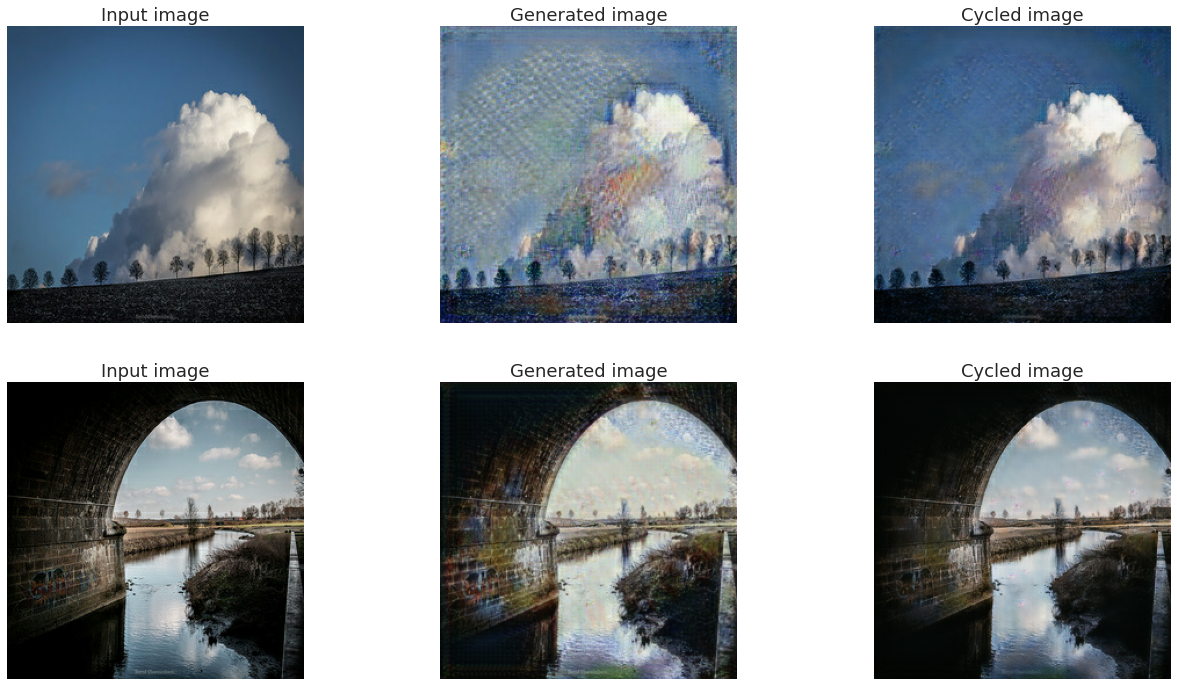

In [81]:
evaluate_cycle(photo_ds_eval.take(2), monet_generator, photo_generator, n_samples=2)

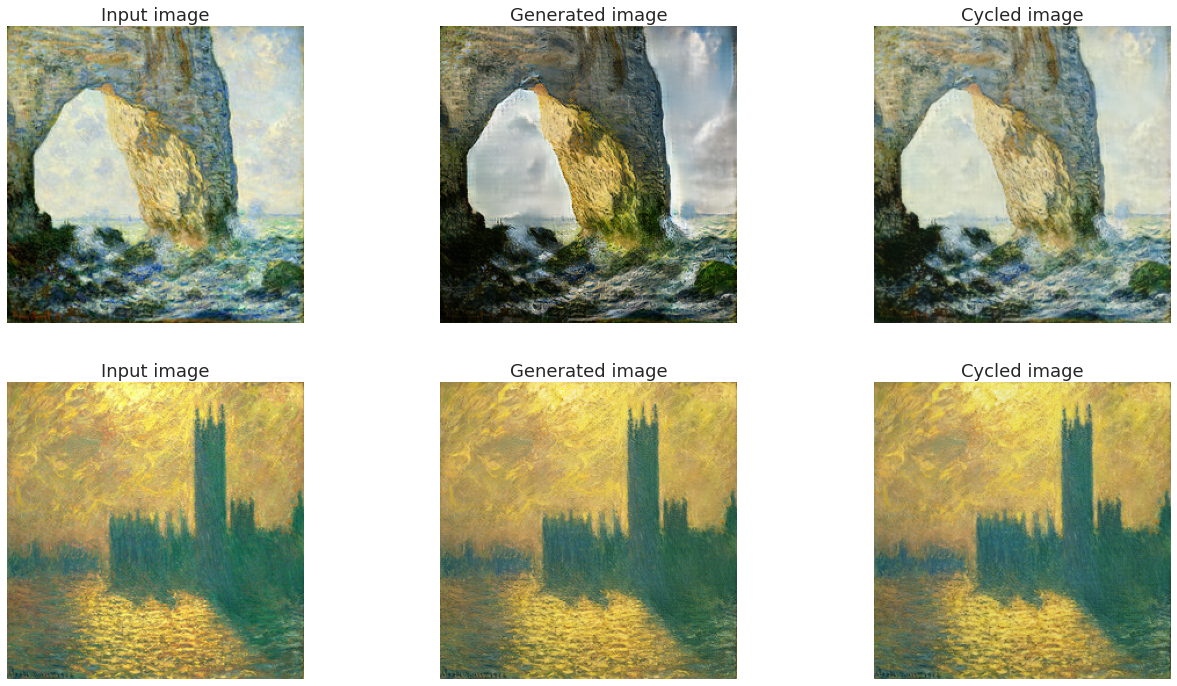

In [82]:
evaluate_cycle(monet_ds_eval.take(2), photo_generator, monet_generator, n_samples=2)

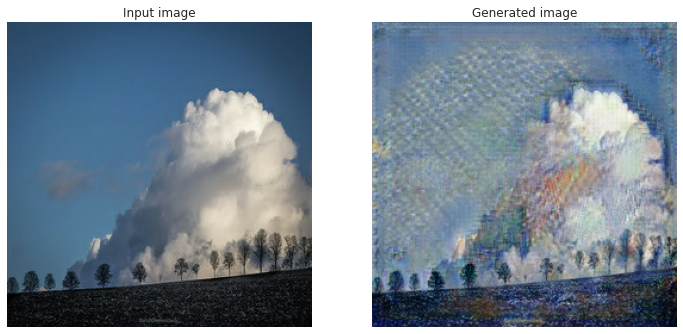

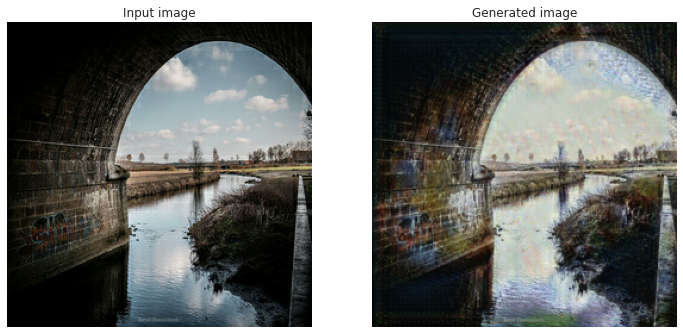

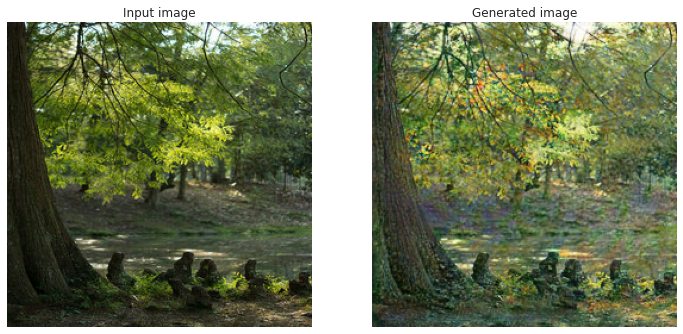

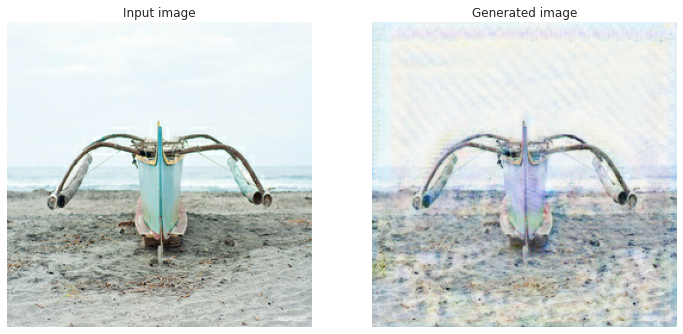

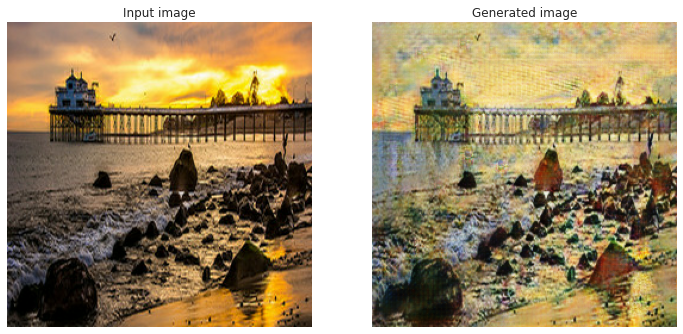

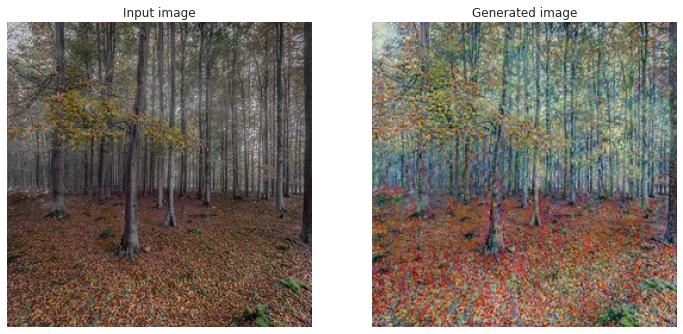

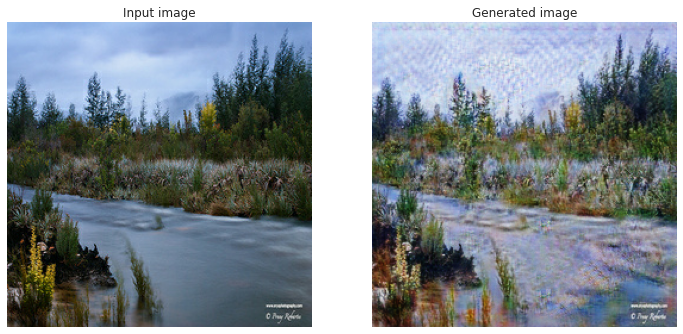

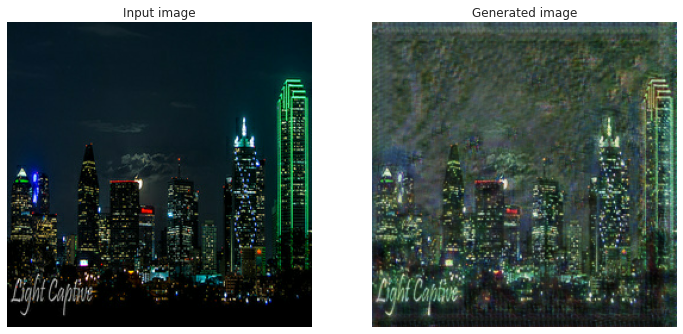

In [83]:
display_generated_samples(photo_ds_eval.take(8), monet_generator, 8)

## Generate Output file

In [85]:
%%time
os.makedirs('../images/') # Create folder to save generated images
predict_and_save(photo_ds_eval, monet_generator, '../images/')

FileExistsError: [Errno 17] File exists: '../images/'

# Submission file

In [86]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 1583


## Output models

In [87]:
monet_generator.save('monet_generator.h5')
photo_generator.save('photo_generator.h5')
monet_discriminator.save('monet_discriminator.h5')
photo_discriminator.save('photo_discriminator.h5')